In [1]:
import glob
import os
import random
import tqdm
import numpy as np
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.models import load_model
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [2]:

IMG_SIZE = 32
img_shape = (IMG_SIZE, IMG_SIZE, 3)

test_data_dir = '/home/ubuntu/.jupyter/indoor_data/test'
test_img_dir = glob.glob('/home/ubuntu/.jupyter/indoor_data/test/class*/frame*.jpg')
print (len(test_img_dir))

test_img = []
# randomly pick 10 images from each class
class_dir = glob.glob('/home/ubuntu/.jupyter/indoor_data/test/class*/')
for i in range(len(class_dir)):
    img_in_class = glob.glob(os.path.join(class_dir[i], 'frame*.jpg'))
    test_img.append(random.sample(img_in_class, 10))

test_img_dir = [i for sub in test_img for i in sub] 
print(len(test_img_dir))


2984
760


In [3]:

# create corresponding one hot encoded label vector

label_list = []
for i in range(len(test_img_dir)):
    label = int(test_img_dir[i].split('/')[-2][-2:])
    label_list.append(label)

label_vec = pd.get_dummies(label_list)
label_vec.iloc[0][label_vec.iloc[0] == 1]


53    1
Name: 0, dtype: uint8

In [4]:
# load image array from image directory

test_img_list = []

for i in range(len(test_img_dir)):
    img_path = test_img_dir[i]
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size = (IMG_SIZE, IMG_SIZE))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)

    test_img_list.append(x)

test_img_array = np.array(test_img_list)
test_img_array.shape


(760, 32, 32, 3)

In [5]:
# channel mean array([118.82756496,  99.98454557,  85.08010847])
def preprocess_input(x):
    
    x[:, :, 0] -= 118.82756496
    x[:, :, 1] -= 99.98454557
    x[:, :, 2] -= 85.08010847
    
    return x


In [6]:
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow(
    test_img_array,
    label_vec,
#     target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = 1,
    shuffle = False)


In [7]:
model = load_model('./models/2019-01-22_indoor_gps_RAN_model_0.0001.h5')

# steps: Total number of steps (batches of samples) to yield from generator before stopping. 
pred = model.predict_generator(test_generator, steps = test_generator.n)


In [ ]:
pred_label = np.argmax(pred, axis = 1)

for i in zip(pred_label, [(i - 1) for i in label_list]):
    print(i)
    

In [9]:

right = 0
wrong = 0
pred_label = np.argmax(pred, axis = 1)

for i in range(len(pred_label)):
    if pred_label[i] == label_list[i] - 1:
        right += 1
    else:
        wrong += 1
        
right/ len(pred_label), wrong/ len(pred_label)



(1.0, 0.0)


### test on all images from the testing data 

In [10]:

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = 1,
    shuffle = False)


pred = model.predict_generator(test_generator, steps = len(test_generator.classes))



Found 2984 images belonging to 76 classes.


In [11]:
right = 0
wrong = 0
pred_label = np.argmax(pred, axis = 1)

for i in range(len(pred_label)):
    if pred_label[i] == test_generator.classes[i]:
        right += 1
    else:
        wrong += 1
        
right/ len(pred_label), wrong/ len(pred_label)


(1.0, 0.0)

In [16]:

# print (np.min(pred_label), np.max(pred_label), np.min(test_generator.classes), np.max(test_generator.classes))

# np.unique(test_generator.classes, return_counts = True)


In [ ]:
target_names = ['class_' + str(i) for i in np.arange(76)]

print(classification_report(test_generator.classes, pred_label, target_names = target_names))

class_names = ['class_' + str(i) for i in np.arange(76)]


Confusion matrix, without normalization
[[20  0  0 ...  0  0  0]
 [ 0 35  0 ...  0  0  0]
 [ 0  0 52 ...  0  0  0]
 ...
 [ 0  0  0 ... 82  0  0]
 [ 0  0  0 ...  0 57  0]
 [ 0  0  0 ...  0  0 67]]


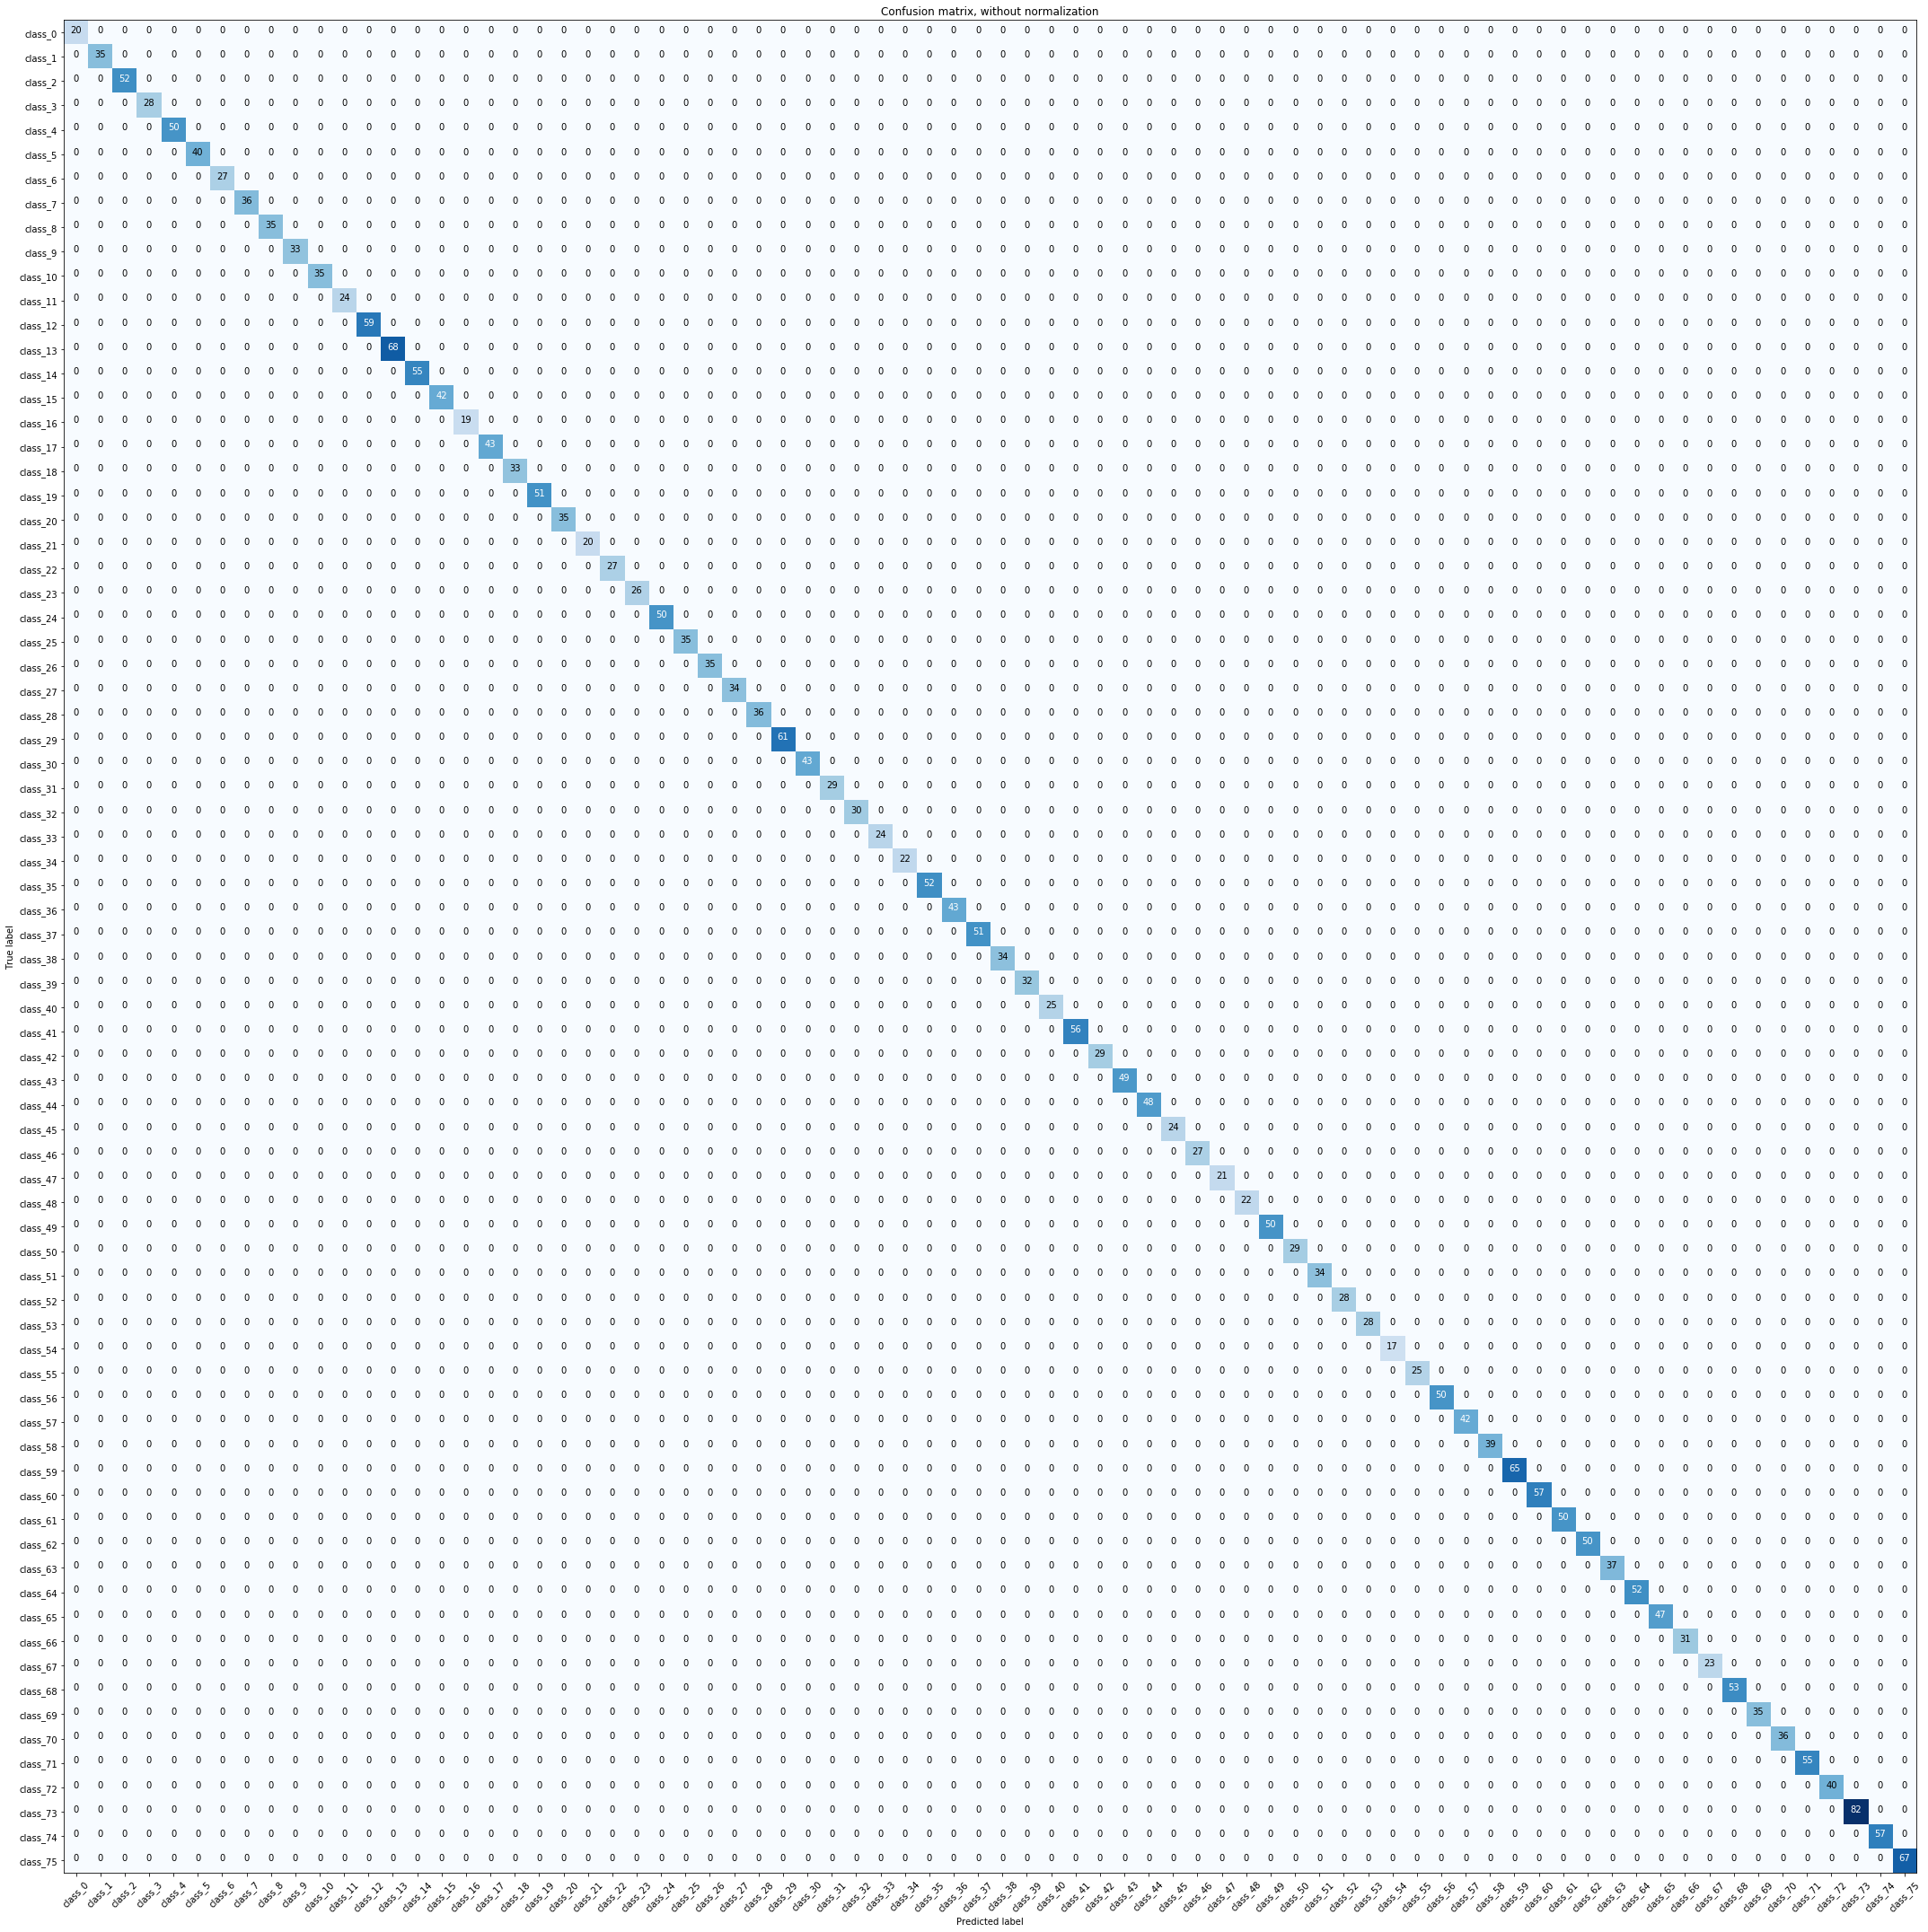

In [15]:

# Split the data into a training set and a test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# # Run classifier, using a model that is too regularized (C too low) to see
# # the impact on the results
# classifier = svm.SVC(kernel='linear', C=0.01)
# y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize = (30, 30))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(test_generator.classes, pred_label)
np.set_printoptions(precision=2)


plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

